Found number of associations for various allele
  frequency/phenotype frequency cutoffs. Heatmaps of adjusted p values.
Determines which associations will be used for BMA. Makes frequency donut
charts.

In [1]:
import os

import pandas as pd
import numpy as np
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
path = os.path.realpath('..')
outpath = os.path.join(path, 'output/compare_cutoff_pvals')

# Get list of phenotypes and haplotypes

In [4]:
phe_list = []
# get names of cancer phe files

cancerphes_file = open(os.path.join(path, "data/cancerphes.txt"), "r")
for line in cancerphes_file.readlines():
    phe_list.append(line[:-1])
cancerphes_file.close()

# get names of HC phe files
for i in range(446):
    # after filtering there are no cases for HC65
    if i != 65:
        phe_list.append("HC" + str(i))

In [5]:
# get haplotype names

hap_list = []

hap_file = open(os.path.join(path, "data/all_haps.txt"),"r")
for line in hap_file.readlines():
    hap_list.append(line[:-1])
hap_file.close()


# Create dataframe with PLINK pvalues from every phe/hap combo

In [6]:
# initialize dataframe
p_df = pd.DataFrame(index = phe_list, columns = hap_list, dtype = float)


In [8]:
# fill dataframe (includes firth regressions)

for phe in phe_list:
    df = pd.read_csv(
        os.path.join(path, "data/PLINK_results/", phe, ".PHENO1.glm.logistic.hybrid"),
        delim_whitespace=True, 
        header=0,
    )
    df = df.loc[df['TEST'] == 'ADD'] 
    for row in df.itertuples(index=True,name="Pandas"):
        p_df[getattr(row,"ID")][phe] = getattr(row,"P")

IOError: File /oak/stanford/groups/mrivas/users/cdeboeve/repos/rivas-lab/hla-assoc/data/PLINK_results/1022/.PHENO1.glm.logistic.hybrid does not exist

In [8]:
p_df
p_df.to_csv(outpath + "all_p_vals.csv")

In [9]:
#p_df = pd.read_csv(outpath + "all_p_vals.csv", index_col = 0, header = 0)

# Subset by frequency

In [10]:
# create allele frequency dictionary
allele_freq_file = open(path + "notebooks/output/check_firth/allele_freq.csv","r")
allele_freq_file.readline()
allele_freq_dict = {}
for line in allele_freq_file.readlines():
    line = line.split(",")
    allele_freq_dict[line[0]] = int(line[1][:-3])
allele_freq_file.close()

In [11]:
allele_freq_dict["A_201"]

180969

In [12]:
# create phe frequency dictionary
phe_freq_file = open(path + "notebooks/output/check_firth/phe_freq.csv","r")
phe_freq_file.readline()
phe_freq_dict = {}
for line in phe_freq_file.readlines():
    line = line.split(",")
    phe_freq_dict[line[0]] = int(line[1][:-1])
phe_freq_file.close()

In [13]:
phe_freq_dict["1060"]

17400

In [14]:
def adjust_pvals(p_df, phe_freq, allele_freq, phe_freq_dict, allele_freq_dict, thresh):
    phe_subset = []
    for phe in phe_freq_dict.keys():
        if phe_freq_dict[phe] > phe_freq:
            phe_subset.append(phe)
    allele_subset = []
    for allele in allele_freq_dict.keys():
        if allele_freq_dict[allele] > allele_freq:
            allele_subset.append(allele)
    # subset dataframe by phe_subset and allele_subset
    sub_df = p_df[allele_subset]
    sub_df = sub_df.loc[phe_subset]
    #print("sub_df shape: {}".format(sub_df))
    # turn into 1-d numpy array of p values
    s = sub_df.as_matrix().shape
    flat_df = sub_df.as_matrix().flatten()
    total = flat_df.shape[0]
    nom_p = robjects.FloatVector(flat_df)
    rpadjust = robjects.r['p.adjust']
    adj_p = np.array(rpadjust(nom_p, "BY"))
    adj_p = np.reshape(adj_p,s)
    # find the number of adjusted values below the threshold
    below_thresh = (adj_p < thresh).sum()
    adj_p_df = pd.DataFrame(adj_p,index=sub_df.index.values, columns=sub_df.columns.values)
    return below_thresh, total, adj_p_df

# Create table with different cutoff values

In [15]:

phe_cutoff = [500,1000,2000]
num_individuals = 337208
allele_cutoff = [5,num_individuals*0.0001,num_individuals*0.001]
res_df = pd.DataFrame(index=phe_cutoff, columns=allele_cutoff)
num_tests = pd.DataFrame(index=phe_cutoff, columns=allele_cutoff)
for i in phe_cutoff:
    for j in allele_cutoff:
        res_df[j][i], num_tests[j][i], dummy_df = adjust_pvals(p_df, float(i), float(j), phe_freq_dict, allele_freq_dict, 0.05)

## Significant p value table

In [16]:
res_df

,5.0,33.7208,337.208
500,703,704,708
1000,649,651,656
2000,579,583,587


## Number of tests table

In [17]:
num_tests

,5.0,33.7208,337.208
500,62640,55620,47250
1000,47096,41818,35525
2000,30392,26986,22925


## Chosen cutoffs: case, 500; allelotype, 0.1% (351)

# Analyze chosen cutoffs

In [18]:
below_thresh, total, adj_p_df = adjust_pvals(p_df, 500, num_individuals*0.001, phe_freq_dict, allele_freq_dict, 0.05)

In [19]:
adj_p_df.to_csv(outpath + "adj_p_vals.csv")

In [20]:
print("shape of adj_p_df: {}".format(adj_p_df.shape))
s = adj_p_df.shape
ones = np.ones((s[1],))
print(ones)
print(adj_p_df.iloc[0].shape)
print(np.all(adj_p_df.iloc[3] == ones))

shape of adj_p_df: (270, 175)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
(175,)
False


## Number of phenotypes and allelotypes using our cutoffs

In [21]:
print("number of phenotypes studied: {}".format(adj_p_df.shape[0]))
print("number of allelotypes studied: {}".format(adj_p_df.shape[1]))

number of phenotypes studied: 270
number of allelotypes studied: 175


In [22]:
adj_loci = set()
for allele in adj_p_df.columns.values:
    adj_loci.add(allele.split("_")[0])
print(adj_loci)
print(len(adj_loci))


set(['A', 'C', 'B', 'DQB1', 'DQA1', 'DPA1', 'DPB1', 'DRB4', 'DRB5', 'DRB1', 'DRB3'])
11


## Breakdown of HC vs cancer 

In [23]:
HC_phe = 0
cancer_phe = 0
for phe in adj_p_df.index.values:
    if phe[:2] == "HC":
        HC_phe += 1
    else:
        cancer_phe += 1
print("cutoff HC phenotypes: {}".format(HC_phe))
print("cutoff cancer phenotypes: {}".format(cancer_phe))

cutoff HC phenotypes: 240
cutoff cancer phenotypes: 30


## Number with significant entries

In [24]:
sig_df = adj_p_df.loc[(adj_p_df < 0.05).sum(axis=1) > 0, :]

In [25]:
sig_df = sig_df[sig_df.columns[(sig_df<0.05).any()]]

In [26]:
print("number of phenotypes with significant entry: {}".format(sig_df.shape[0]))
print("number of allelotypes with significant entry: {}".format(sig_df.shape[1]))

number of phenotypes with significant entry: 64
number of allelotypes with significant entry: 112


## Create heatmaps of nominal p values

In [27]:
def neglog10(x):
    return -np.log10(x)

In [28]:
log_sig_df = sig_df.replace(0, np.nextafter(0,1))
log_sig_df = log_sig_df.applymap(neglog10)

In [29]:
print("significance threshold: {}".format(-np.log10(0.05)))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC303","DQA1_501",log_sig_df["DQB1_501"]["HC303"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC303","DQB1_201",log_sig_df["DQB1_201"]["HC303"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC430","DRB1_101",log_sig_df["DRB1_101"]["HC430"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC430","DRB1_404",log_sig_df["DRB1_404"]["HC430"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC151","DRB1_1501",log_sig_df["DRB1_1501"]["HC151"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC151","DQB1_602",log_sig_df["DQB1_602"]["HC151"]))
print("phenotype: {} allelotype: {} -log_10 nominal pval: {}"
      .format("HC352","DRB1_301",log_sig_df["DRB1_301"]["HC352"]))

significance threshold: 1.30102999566
phenotype: HC303 allelotype: DQA1_501 -log_10 nominal pval: 37.2616793927
phenotype: HC303 allelotype: DQB1_201 -log_10 nominal pval: 323.306215343
phenotype: HC430 allelotype: DRB1_101 -log_10 nominal pval: 4.95884664414
phenotype: HC430 allelotype: DRB1_404 -log_10 nominal pval: 14.8254684783
phenotype: HC151 allelotype: DRB1_1501 -log_10 nominal pval: 105.704709438
phenotype: HC151 allelotype: DQB1_602 -log_10 nominal pval: 99.601001135
phenotype: HC352 allelotype: DRB1_301 -log_10 nominal pval: 8.33451301396


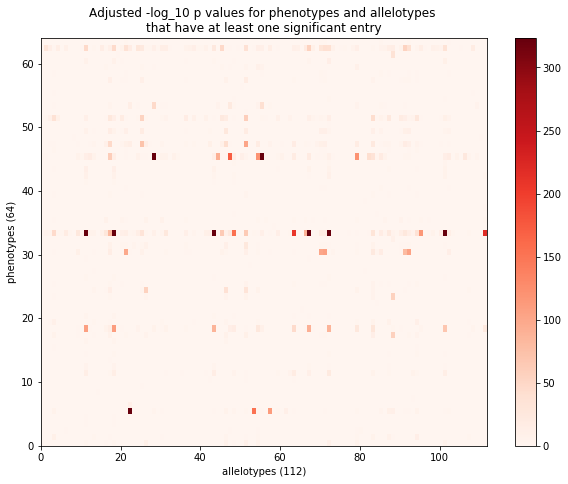

In [30]:
plt.pcolor(log_sig_df, cmap='Reds')
plt.colorbar()
plt.xlabel("allelotypes (" + str(sig_df.shape[1]) + ")")
plt.ylabel("phenotypes (" + str(sig_df.shape[0]) + ")")
plt.title("Adjusted -log_10 p values for phenotypes and allelotypes \nthat have at least one significant entry")
fig = plt.gcf()
fig.set_size_inches(10, 7.5)
plt.savefig(outpath + 'adj_p_heatmap_sig.svg')
plt.show()


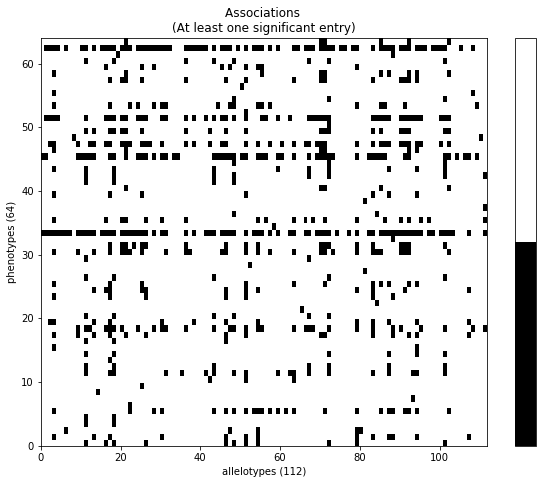

In [31]:
plt.close()
cmap = colors.ListedColormap(['black','white'])
bounds = [0, 0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.pcolor(sig_df, cmap=cmap, norm=norm)
cb = plt.colorbar()
cb.set_ticks([])
plt.xlabel("allelotypes (" + str(sig_df.shape[1]) + ")")
plt.ylabel("phenotypes (" + str(sig_df.shape[0]) + ")")
plt.title("Associations \n(At least one significant entry)")
fig = plt.gcf()
fig.set_size_inches(10, 7.5)
plt.savefig(outpath + 'adj_p_heatmap_sig_binary.svg')
plt.show()

In [32]:
log_adj_p_df = adj_p_df.replace(0, np.nextafter(0,1))
log_adj_p_df = log_adj_p_df.applymap(neglog10)

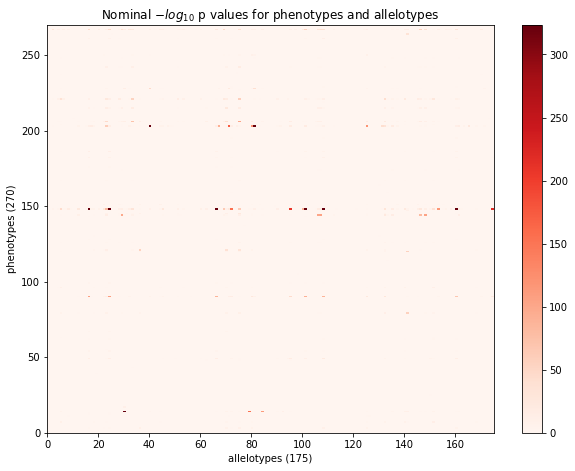

In [33]:
plt.pcolor(log_adj_p_df, cmap='Reds')
plt.colorbar()
plt.xlabel("allelotypes (" + str(adj_p_df.shape[1]) + ")")
plt.ylabel("phenotypes (" + str(adj_p_df.shape[0]) + ")")
plt.title("Nominal $-log_{10}$ p values for phenotypes and allelotypes")
fig = plt.gcf()
fig.set_size_inches(10, 7.5)
plt.savefig(outpath + 'adj_p_heatmap_all.png')
plt.show()


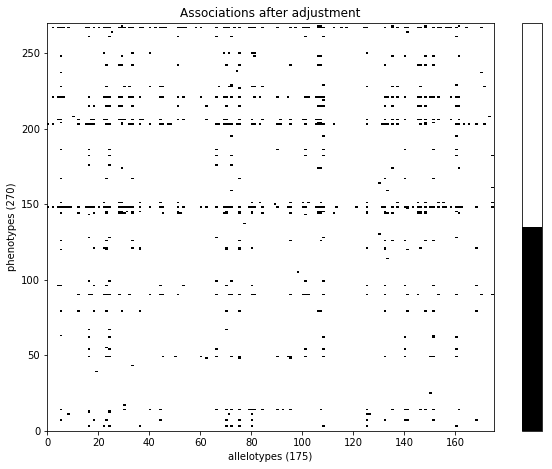

In [34]:
plt.close()
cmap = colors.ListedColormap(['black','white'])
bounds = [0, 0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.pcolor(adj_p_df, cmap=cmap, norm=norm)
cb = plt.colorbar()
cb.set_ticks([])
plt.xlabel("allelotypes (" + str(adj_p_df.shape[1]) + ")")
plt.ylabel("phenotypes (" + str(adj_p_df.shape[0]) + ")")
plt.title("Associations after adjustment")
fig = plt.gcf()
fig.set_size_inches(10, 7.5)
plt.savefig(outpath + 'adj_p_heatmap_all_binary.png')
plt.show()

In [35]:
s = adj_p_df.shape
ones_allele = np.ones((s[0],))
sig_alleles = []
insig_alleles = []
for allele in adj_p_df.columns.values:
    if np.all(adj_p_df[allele] == ones_allele):
        insig_alleles.append(allele)
    else:
        sig_alleles.append(allele)

In [36]:
print("allelotypes not all 1: {}".format(len(sig_alleles)))
print("allelotypes all 1: {}".format(len(insig_alleles)))

allelotypes not all 1: 163
allelotypes all 1: 12


# Create file with all the allelotypes we'll consider for each phenotype for BMA

In [37]:
#BMA_haps = open(outpath + "BMA_haps.csv", "w")
hap_num = 29
BMA_haps = open(outpath + "BMA_haps_" + str(hap_num) + ".csv", "w")

HC_phe_file = open(outpath + "sig_phe_HC.txt","w")
cancer_phe_file = open(outpath + "sig_phe_cancer.txt","w")
count = 0
BMA_phe_torun = []
BMA_allele_torun = set()
phe_sig_dict = {}


for phe in sig_df.index.values:
    
    phe_df = sig_df.loc[phe]
    phe_p = []
    phe_allele = []
    for index, value in phe_df.iteritems():
        if value < 0.05:
            phe_p.append(value)
            phe_allele.append(index)
    sorted_alleles = [x for _,x in sorted(zip(phe_p, phe_allele), reverse = False)]
    phe_sig_dict[phe] = len(sorted_alleles)
    if len(sorted_alleles) > hap_num:
        sorted_alleles = sorted_alleles[:hap_num]
    if len(sorted_alleles) > 1:
        BMA_phe_torun.append(phe)
        if phe[:2] == "HC":
            HC_phe_file.write(phe + " ")
        else:
            cancer_phe_file.write(phe + " ")
        count += 1
        #print(sorted_alleles)
        BMA_haps.write(phe)
        for i in range(hap_num):
            if len(sorted_alleles) > i:
                BMA_haps.write("," + sorted_alleles[i])
                BMA_allele_torun.add(sorted_alleles[i])
            else:
                BMA_haps.write(",")
        BMA_haps.write("\n")
    #print(phe_p)
    #print(phe_allele)
    
BMA_haps.close()
HC_phe_file.close()
cancer_phe_file.close()


    #phe_df = phe_df[phe_df.columns[(phe_df<0.05).any()]]
    #print(phe_df)

## Number of phenotypes and allelotypes we run for BMA

In [38]:
print("number phenotypes running: {}".format(len(BMA_phe_torun)))
print("number allelotypes running: {}".format(len(BMA_allele_torun)))
print(BMA_phe_torun)
print("A_201" in BMA_allele_torun)

number phenotypes running: 48
number allelotypes running: 62
['HC136', '1060', 'HC28', 'HC25', 'HC22', 'HC422', 'HC298', 'HC170', 'HC179', '1053', '1055', 'HC17', 'HC201', 'HC55', '1003', 'HC243', 'HC95', 'HC96', '1041', '1047', 'HC150', 'HC151', 'HC156', 'HC303', 'HC49', 'HC401', '1037', 'HC273', 'HC295', 'HC352', 'HC125', 'HC85', 'HC38', 'HC39', 'HC430', 'HC432', 'HC221', 'HC382', 'HC91', 'HC310', 'HC169', 'HC78', 'HC269', 'HC261', 'HC321', 'HC322', 'HC219', 'HC215']
False


In [39]:
BMA_phe_torun_file = open(outpath + "BMA_phe_torun.txt","w")
for phe in BMA_phe_torun:
    BMA_phe_torun_file.write(phe + " ")
BMA_alleles_torun_file = open(outpath + "BMA_allele_torun.txt","w")
BMA_phe_torun_file.close()
for allele in BMA_allele_torun:
    BMA_alleles_torun_file.write(allele + " ")
BMA_alleles_torun_file.close()


In [40]:
print("number of BMA analyses: {}".format(count))

number of BMA analyses: 48


In [41]:
for phe in phe_sig_dict.keys():
    num_sig = phe_sig_dict[phe]
    if num_sig > 50:
        print("{}: {} significant allelotypes".format(phe, num_sig))

HC303: 74 significant allelotypes
HC38: 52 significant allelotypes
HC219: 71 significant allelotypes


# Create allelotype frequency plots

In [42]:

loci_freq_dict = {'A' : [[],[]], 'C' : [[],[]], 'B' : [[],[]], 'DQB1' : [[],[]], 'DQA1' : [[],[]], 'DPA1' : [[],[]], 'DPB1' : [[],[]], 'DRB4' : [[],[]], 'DRB5' : [[],[]], 'DRB1' : [[],[]], 'DRB3' : [[],[]]}
for allele in allele_freq_dict.keys():
    locus = allele.split("_")[0]
    loci_freq_dict[locus][0].append(allele)
    loci_freq_dict[locus][1].append(allele_freq_dict[allele])
    


In [43]:
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 5 else ''

In [44]:
name_conv = {}
name_conv_file = open(path + "data/ukb_to_asterisk_names.csv","r")
name_conv_file.readline()
for line in name_conv_file.readlines():
    line = line.split(",")
    name_conv[line[0]] = line[1][:-1]
name_conv_file.close()


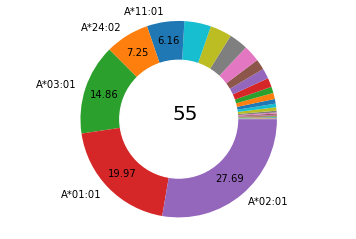

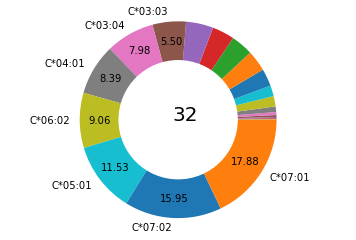

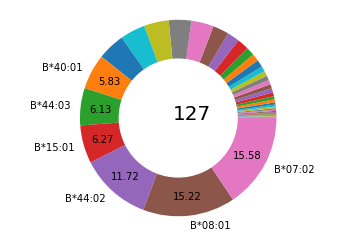

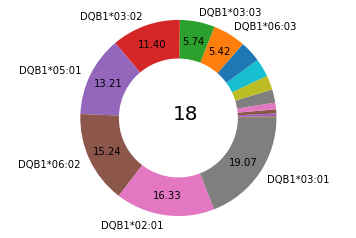

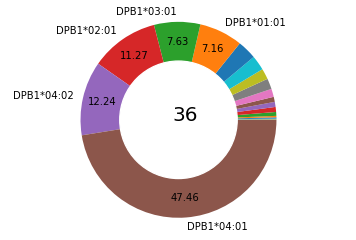

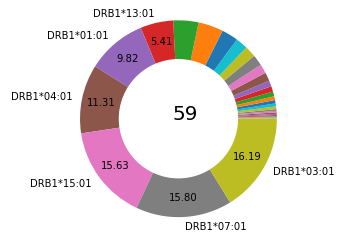

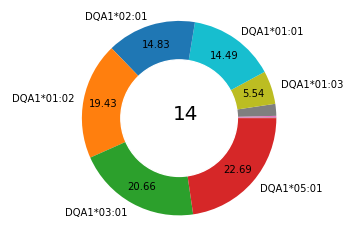

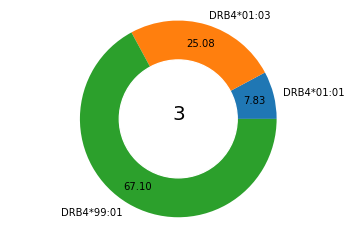

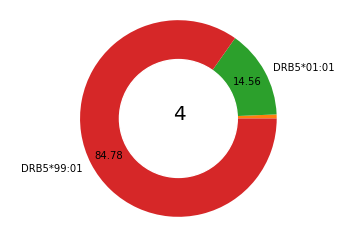

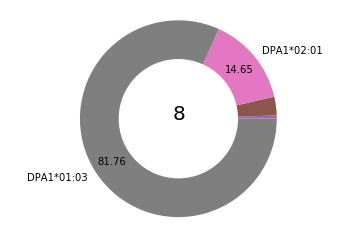

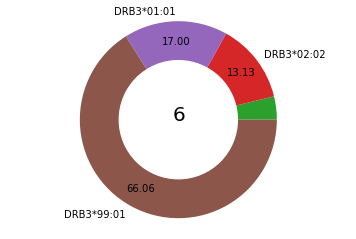

In [45]:
for locus in loci_freq_dict.keys():
    
    val, lab = zip(*sorted(zip(loci_freq_dict[locus][1], loci_freq_dict[locus][0])))
    total = sum(val)
    new_lab = []
    for i in range(len(lab)):
        if val[i]/float(total) < 0.05:
            new_lab.append("")
        else:
            new_lab.append(name_conv[lab[i]])
    plt.pie(val, labels=new_lab, autopct=my_autopct, pctdistance=0.8)
    plt.figtext(0.5,0.5,str(len(val)), size=20)
    centre_circle = plt.Circle((0,0),0.6,color='white', fc='white',linewidth=1.25)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.axis('equal')
    plt.savefig(outpath + locus + "_freq_pie.svg")
    plt.show()

## Create frequency csvs

In [46]:
#loci = ['A', 'C', 'B', 'DQB1', 'DQA1', 'DPA1', 'DPB1', 'DRB4', 'DRB5', 'DRB1', 'DRB3']
#file_dict = {}


for locus in loci_freq_dict.keys():
    f = open(outpath + locus + "_freq.csv","w")
    f.write("allelotype,frequency\n")
    for i in range(len(loci_freq_dict[locus][0])):
        f.write(name_conv[loci_freq_dict[locus][0][i]] + "," + str(loci_freq_dict[locus][1][i]) + "\n")
    f.close()


    